---
# Maps of Vessel Time Exposure
---

Use `analysis-rachael/env/monte_carlo.yaml` to create an environment for this notebook:
```
 conda env create -f [analysis-rachael/env/monte_carlo.yaml]
```
or, to activate this environment, use
```
 conda activate monte-carlo
```
To deactivate an active environment, use
```
 conda deactivate
```

In [1]:
import os
import numpy
import pandas
import xarray
import netCDF4 as nc
import rioxarray
from array import *
from cmocean import cm as cmo
from glob import glob
from cartopy import feature
import cartopy.crs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean
import matplotlib as mpl
import matplotlib.ticker as mticker
from matplotlib import pyplot as plt, patches, colors
# used to make subplot labels consistent between figures
from matplotlib.offsetbox import AnchoredText

from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
#from salishsea_tools import geo_tools, tidetools

In [2]:
if os.sys.platform=="darwin":
    grid_dir = Path('/Volumes/Elements/MIDOSS_Data')
    topo_dir = Path('/Volumes/Elements/MIDOSS_Data')
    geotiff_directory = Path('/Volumes/Elements/MIDOSS_Data/geotiffs/')
    graphics_dir = Path('/Users/rmueller/Projects/MIDOSS/Publications/MIDOSS_MuellerEtAl/JGR_graphics')
    plt.style.use(r"../../style_templates/JGR2023_matplotlibrc.template")
else:
    grid_dir = Path('/data/bmoorema/MEOPAR/grid/')
    topo_dir = Path('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/')
    graphics_dir = Path('/ocean/rmueller/MIDOSS/graphics/')
    geotiff_directory = Path('/data/MIDOSS/geotiffs')

In [3]:
mask = xarray.open_dataset(grid_dir/'mesh_mask201702.nc')
lat = mask['nav_lat'][1:-1,1:-1]
lon = mask['nav_lon'][:]

In [4]:
# larger, presentation-size graphics require different xy text specifications
graphics_size='large'
    
# mapping specifications
rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = cartopy.crs.PlateCarree()
# linewidth for coast/rivers
lw=0.3
# reducd dpi to make smaller graphics
custom_dpi=600

# Create 2018 Vessel Time Exposure maps

In [5]:
ship_types = [
    'tanker', 
    'atb', 
    'barge', 
    'cargo',
    'ferry',  
    'other',
    'smallpass',
    'fishing',
    'cruise',
    'all'
]
months = array('i',range(1,13))
vte={} # vessel time exposure by monts
max_vte=[] # list of maximum VTE across months, by ship
all_vte=[] # combined sum of VTE across months and ship type to compare with "all" .tiffs

# Add VTE across all months in 2018
for ship in ship_types:
    for month in months:
        if month==1:
            vte[ship] = rioxarray.open_rasterio(
                geotiff_directory/f"{ship}_2018_{month:02.0f}.tif",
                masked=True
            )
            # store max value across all vessels
            max_val = vte[ship][0].max().values.item()
        else:
            vte_monthly = rioxarray.open_rasterio(
                geotiff_directory/f"{ship}_2018_{month:02.0f}.tif",
                masked=True
            )
            vte[ship] += vte_monthly
            max_val = max(max_val,vte_monthly.max().values.item())
    max_val_total = vte[ship][0].max().values.item()
    vte[ship] = vte[ship].where(vte[ship]!=0)
    
    # Collate list of max VTE across months by ship type
    max_vte.append(max_val)
    # Add all ship VTE to compare with all_2018_XX.tif summed across XX
    if ship != 'all':
        try:
            all_vte += vte[ship]
        except ValueError:
            all_vte = vte[ship]

In [6]:
#da = rioxarray.open_rasterio(geotiff_directory/"all_2018_01.tif",masked=True)
ship = 'cargo'
# create plotting mesh and set all zero and _FillValues to NaN 
x, y = numpy.meshgrid(vte[ship].x, vte[ship].y)
# set the interval between levels
step = (
    numpy.ceil(numpy.log10(numpy.max(max_val_total))) - numpy.floor(numpy.log10(0.01)))/50
# graphic levels
lev_exp = numpy.arange(
    numpy.floor(numpy.log10(0.01)),
    numpy.ceil(numpy.log10(max_val_total)),
    step
)
# for log-scale plot
levs = numpy.power(10, lev_exp)

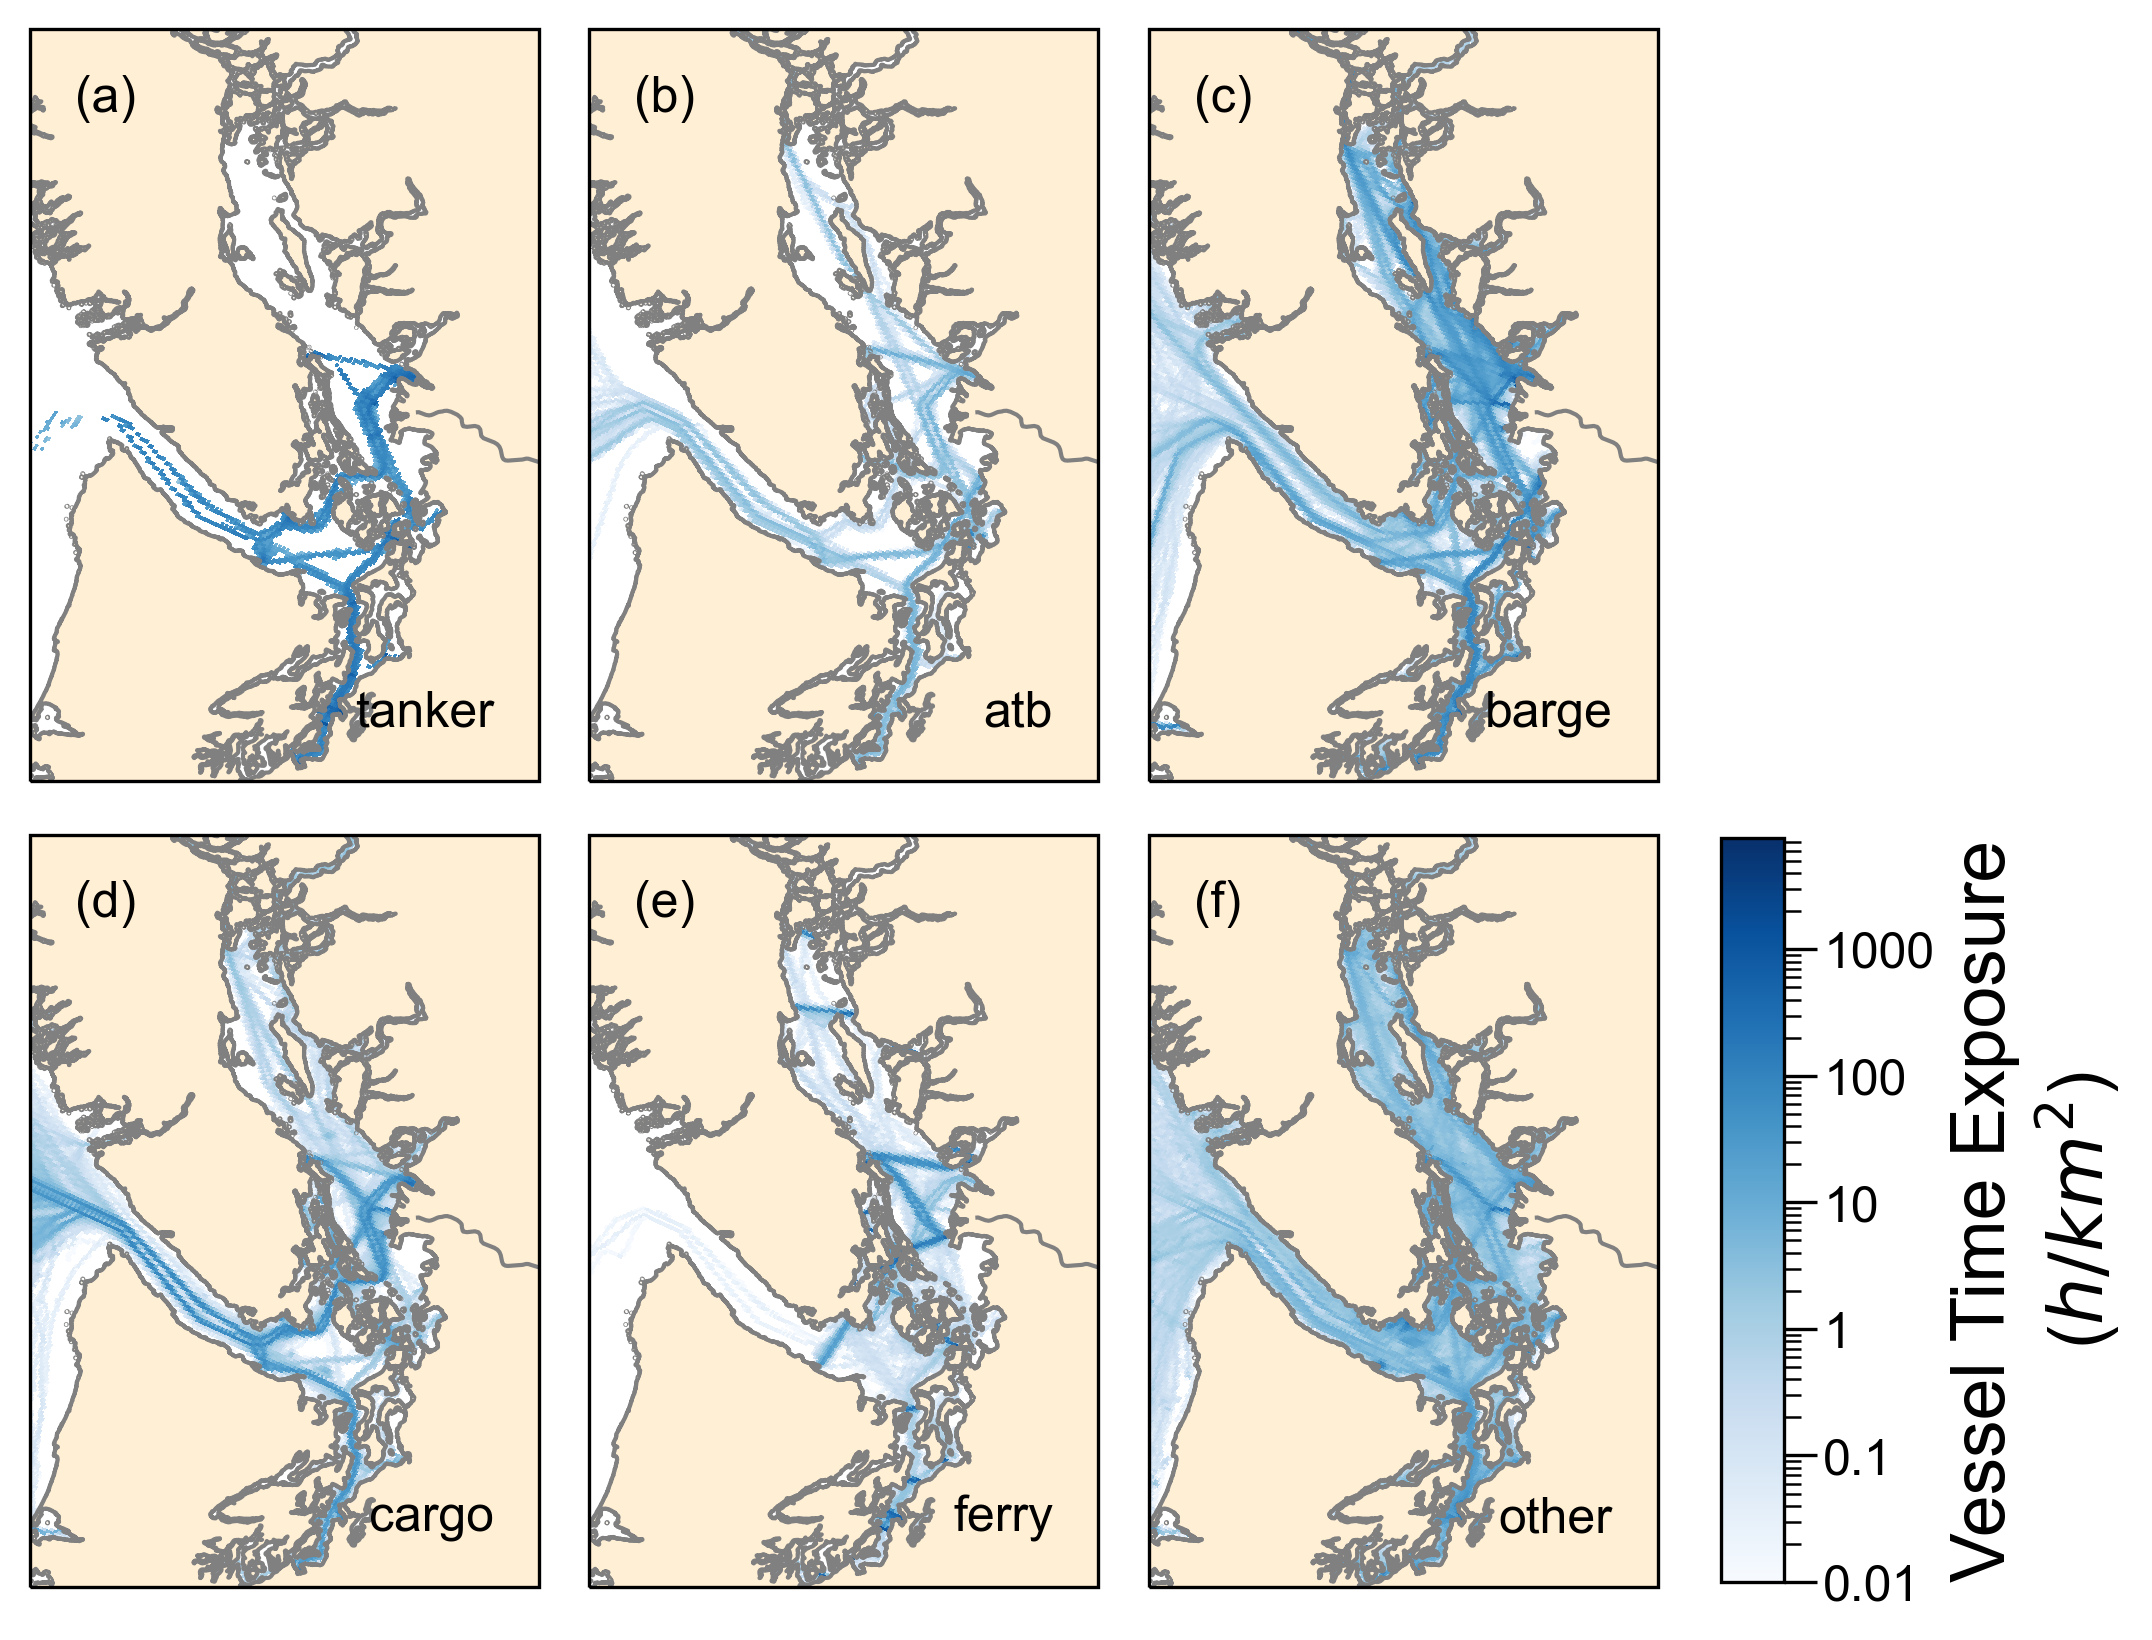

In [9]:
ec='grey'
lw=1
fs=12
ship_types = [
    'tanker', 
    'atb', 
    'barge', 
    'cargo',
    'ferry',  
    'other'
]

# add suplot labels
subplot_labels=['(a)','(b)','(c)','(d)','(e)','(f)']

fig, ax = plt.subplots(2, 3, 
              figsize=(7, 8), #(width, height)
              subplot_kw={'projection': rotated_crs, 
                "facecolor": "white"},
              gridspec_kw={
                   'width_ratios': [1,1,1],
                   'height_ratios': [1,1],
                   'wspace': 0.1,
                  'hspace':-.2}
)

for idx,ship in enumerate(ship_types):
    if idx<3:
        ax[0,idx].set_extent([-124, -123.75, lat.min()-0.15, lat.max()])
        # add text with ship type
        anchored_text_ul = AnchoredText(
            subplot_labels[idx], 
            loc="upper left",
            prop=dict(size=fs),frameon=False
        )
        anchored_text_lr = AnchoredText(
            ship, loc="lower right",
            prop=dict(size=fs),frameon=False
        )
        ax[0,idx].add_artist(anchored_text_ul)
        ax[0,idx].add_artist(anchored_text_lr)
        #ax[0,idx].text(-45.99,0.682*lat.max(),ship)
        ax[0,idx].add_feature(feature.GSHHSFeature(
            'full', edgecolor=ec, linewidth=lw, facecolor='papayawhip'))
        ax[0,idx].add_feature(feature.NaturalEarthFeature(
            category='physical', name='rivers_lake_centerlines',
            scale='10m', facecolor='none', linewidth=lw, edgecolor=ec,
        ))
        C=ax[0,idx].pcolormesh(x, y, 
            vte[ship][0],
            vmin=levs[0],
            vmax=levs[-1],
            cmap=cmo.cm.Blues, 
            norm=colors.LogNorm(),
            transform=plain_crs)
#         # add lat/lon lines
#         gl = ax[0,idx].gridlines(linestyle="--", color='gray', alpha=0.5, draw_labels=False, dms=True, x_inline=False, y_inline=False)
       
    else:
        ax[1,idx-3].set_extent([-124, -123.75, lat.min()-0.15, lat.max()])
        # add text with ship type
        anchored_text_ul = AnchoredText(
            subplot_labels[idx], 
            loc="upper left",
            prop=dict(size=fs),frameon=False
        )
        anchored_text_lr = AnchoredText(
            ship, loc="lower right",
            prop=dict(size=fs),frameon=False
        )
        ax[1,idx-3].add_artist(anchored_text_ul)
        ax[1,idx-3].add_artist(anchored_text_lr)
        #ax[1,idx-3].text(-45.99,0.682*lat.max(),ship)
        ax[1,idx-3].add_feature(feature.GSHHSFeature(
            'full', edgecolor=ec, linewidth=lw, facecolor='papayawhip'))
        ax[1,idx-3].add_feature(feature.NaturalEarthFeature(
            category='physical', name='rivers_lake_centerlines',
            scale='10m', facecolor='none', linewidth=lw, edgecolor=ec,
        ))
        C=ax[1,idx-3].pcolormesh(x, y, 
            vte[ship][0],
            vmin=levs[0],
            vmax=levs[-1],
            cmap=cmo.cm.Blues, 
            norm=colors.LogNorm(),
            transform=plain_crs)
        # # add lat/lon lines
        # if (idx == 4):
        #     gl = ax[1,idx-3].gridlines(linestyle="--", color='gray', alpha=0.5, draw_labels=True, dms=True, x_inline=False, y_inline=False)
        #     gl.top_labels, gl.right_labels = False, False
        # else:
        #     gl = ax[1,idx-3].gridlines(linestyle="--", color='gray', alpha=0.5, draw_labels=False, dms=True, x_inline=False, y_inline=False)
       
cb_ax = fig.add_axes([.93,.18,.03,.31])
cb = fig.colorbar(C, 
    cax=cb_ax, 
    ticks=[1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
    pad=0.1
    );

#cb.set_ticks([1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3])
cb.set_ticklabels(['0.01', '0.1', '1', '10', '100', '1000'])
minorticks = C.norm(numpy.arange(1, 10, 2))
cb.ax.xaxis.set_ticks(minorticks, minor=True)
cb.ax.tick_params(labelsize=12)
cb.ax.tick_params(which='major', length=8, color='k') 
cb.ax.tick_params(which='minor', length=4, color='k')
cb.ax.minorticks_on()
cb.set_label('Vessel Time Exposure\n($h/km^2$)');
if custom_dpi>=600:
    plt.savefig(graphics_dir/'Figure3_VTE_allTraffic.png')
else:
    plt.savefig(graphics_dir/'Figure3_VTE_allTraffic_small.png')
    
plt.show()